# Задание

Вариант 1: Разработать программу, выполняющую кластеризацию пороговым методом. Для вычисления расстояний между образами необходимо использовать формулу расстояния Евклида и расстояния Канберра.

# Реализация

Зададим множество точек (образов) для дальнейшей кластеризации.

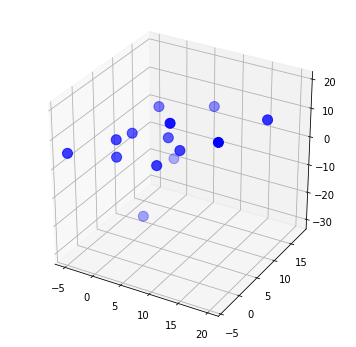

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = np.array([
    (0,1,1), (0,1,7), (5,7,4), (0,5,5), (9,4,5), (7,1,2), (10,0,19),
    (0,12,7), (-5,-4,5), (20,10,15), (0,16,-16), (-1,9,-30),
    (18,0,17), (6,18,4)
], dtype='float32')

x, y, z = data.T
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o', s=100)
plt.show()

Функции для расчета расстояния между точками. Используется расстояние Евклида:

$$ \sum_{i=1}^{n} (x_i - y_i)^2. $$

И расстояние Канберра:

$$ \sum_{i=1}^{n} \left|\dfrac{x_i - y_i}{\left| x_i \right| + \left| y_i \right|}\right| $$

При вычислении расстояния Канберра возможно деление на ноль, поэтому все нули в знаменателе заменяются на $10^{-5}$.

In [2]:
def euclidian_distances(x, y, p=2):
    return np.sum((x - y)**p, axis=1)

def canberra_distances(x, y):
    divisor = np.abs(x)+np.abs(y)
    np.place(divisor, (divisor == 0), 1e-5)
    return np.sum(np.abs((x-y)/divisor), axis=1)

Реализуем функцию кластеризации в соответствии выбранным методом и пару вспомогательных функций

In [3]:
def calculate_distances(func, image, clusters):
    """Вспомогательная функция для вычисления расстояния между
    заданным образом и кластерами"""
    image_t = np.tile(image, (clusters.shape[0], 1))
    distance = func(image_t, clusters)
    return distance

def calculate_cluster_center(cluster):
    """Вычисляет геометрическое среднее"""
    return np.sqrt(np.sum(cluster**2, axis=0))/cluster.shape[0]

def clusterize(data, threshold, func):
    """Выполняет кластеризацию данных, используя заданный порог
    и функцию вычисления расстояния"""
    clusters_centers = data[:1].copy()
    clusters_images = [data[:1].copy()]
    for image in data[1:]:
        distances = calculate_distances(func, image, clusters_centers)
        if np.all(distances > threshold):
            # новый кластер
            clusters_centers = np.append(
                clusters_centers, np.array([image.copy()]), axis=0)
            clusters_images.append(np.array([image.copy()]))
        else:
            # добавляю в существующий кластер
            idx = np.argmin(distances)
            newcluster = np.append(
                clusters_images[idx],
                np.array([image.copy()]), axis=0)
            clusters_images[idx] = newcluster
            clusters_centers[idx] = calculate_cluster_center(newcluster)
    # форматирование данных
    number_of_clusters = len(clusters_centers)
    result = np.zeros((number_of_clusters, 2), dtype='O')
    for i in range(number_of_clusters):
        result[i,0] = clusters_centers[i]
        result[i,1] = clusters_images[i]
    return result

Теперь можно поэксперементировать с кластеризацией, выбирая предел и функцию расстояния.

In [4]:
from pprint import pprint

def generate_colors_and_markers(n):
    markers = 'o^*hDsv<>x+'
    result = []
    to_hex = lambda x: x.astype('uint8').tobytes().hex()
    for i in range(n):
        base_color = (42+np.random.random(3)*171)
        cluster_center_color = '#' + to_hex(base_color * 1.05)
        point_color = '#' + to_hex(base_color)
        result.append((cluster_center_color, point_color, markers[i]))
    return result

def try_clusterize(threshold, func):
    clusterized_data = clusterize(data, threshold, func)
    # dict repr
    dict_repr = {
        tuple(map((lambda p: round(p, 2)), x[0].tolist())):
            list(map(tuple, x[1].tolist()))
        for x in clusterized_data
    }
    pprint(dict_repr, width=65)
    # 3d plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    cms = generate_colors_and_markers(clusterized_data.shape[0])
    for cluster, cm in zip(clusterized_data, cms):
        cx, cy, cz = cluster[0].T
        x, y, z = cluster[1].T
        ax.scatter(cx, cy, cz, c=cm[0], marker=cm[2], s=1000, alpha=0.3)
        ax.scatter(x, y, z, c=cm[1], marker=cm[2], s=30, alpha=1)
    plt.show()

Расстояние Евклида.

{(-5.0, -4.0, 5.0): [(-5.0, -4.0, 5.0)],
 (-1.0, 9.0, -30.0): [(-1.0, 9.0, -30.0)],
 (0.0, 12.0, 7.0): [(0.0, 12.0, 7.0)],
 (0.0, 16.0, -16.0): [(0.0, 16.0, -16.0)],
 (2.07, 1.61, 1.83): [(0.0, 1.0, 1.0),
                      (0.0, 1.0, 7.0),
                      (5.0, 7.0, 4.0),
                      (0.0, 5.0, 5.0),
                      (9.0, 4.0, 5.0),
                      (7.0, 1.0, 2.0)],
 (6.0, 18.0, 4.0): [(6.0, 18.0, 4.0)],
 (10.3, 0.0, 12.75): [(10.0, 0.0, 19.0), (18.0, 0.0, 17.0)],
 (20.0, 10.0, 15.0): [(20.0, 10.0, 15.0)]}


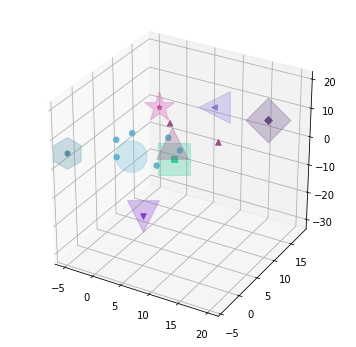

In [5]:
try_clusterize(80, euclidian_distances)

{(-1.0, 9.0, -30.0): [(-1.0, 9.0, -30.0)],
 (0.0, 16.0, -16.0): [(0.0, 16.0, -16.0)],
 (1.68, 1.99, 1.74): [(0.0, 1.0, 1.0),
                      (0.0, 1.0, 7.0),
                      (5.0, 7.0, 4.0),
                      (0.0, 5.0, 5.0),
                      (9.0, 4.0, 5.0),
                      (7.0, 1.0, 2.0),
                      (0.0, 12.0, 7.0),
                      (-5.0, -4.0, 5.0)],
 (6.0, 18.0, 4.0): [(6.0, 18.0, 4.0)],
 (10.3, 0.0, 12.75): [(10.0, 0.0, 19.0), (18.0, 0.0, 17.0)],
 (20.0, 10.0, 15.0): [(20.0, 10.0, 15.0)]}


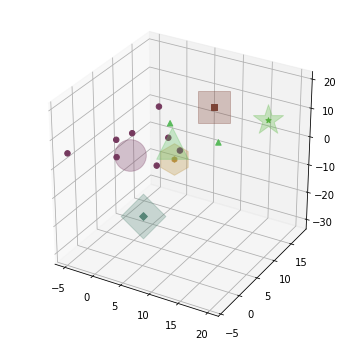

In [6]:
try_clusterize(180, euclidian_distances)

{(0.5, 9.18, 17.0): [(0.0, 16.0, -16.0), (-1.0, 9.0, -30.0)],
 (1.68, 1.99, 1.74): [(0.0, 1.0, 1.0),
                      (0.0, 1.0, 7.0),
                      (5.0, 7.0, 4.0),
                      (0.0, 5.0, 5.0),
                      (9.0, 4.0, 5.0),
                      (7.0, 1.0, 2.0),
                      (0.0, 12.0, 7.0),
                      (-5.0, -4.0, 5.0)],
 (7.33, 5.15, 7.46): [(10.0, 0.0, 19.0),
                      (20.0, 10.0, 15.0),
                      (18.0, 0.0, 17.0),
                      (6.0, 18.0, 4.0)]}


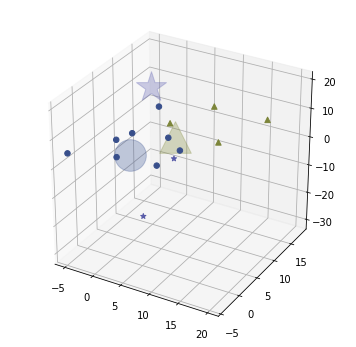

In [7]:
try_clusterize(280, euclidian_distances)

Расстояние Канберра.

{(-5.0, -4.0, 5.0): [(-5.0, -4.0, 5.0)],
 (-1.0, 9.0, -30.0): [(-1.0, 9.0, -30.0)],
 (0.0, 3.27, 2.78): [(0.0, 1.0, 1.0),
                     (0.0, 1.0, 7.0),
                     (0.0, 5.0, 5.0),
                     (0.0, 12.0, 7.0)],
 (0.0, 16.0, -16.0): [(0.0, 16.0, -16.0)],
 (4.15, 2.71, 2.24): [(5.0, 7.0, 4.0),
                      (9.0, 4.0, 5.0),
                      (7.0, 1.0, 2.0)],
 (6.0, 18.0, 4.0): [(6.0, 18.0, 4.0)],
 (10.3, 0.0, 12.75): [(10.0, 0.0, 19.0), (18.0, 0.0, 17.0)],
 (20.0, 10.0, 15.0): [(20.0, 10.0, 15.0)]}


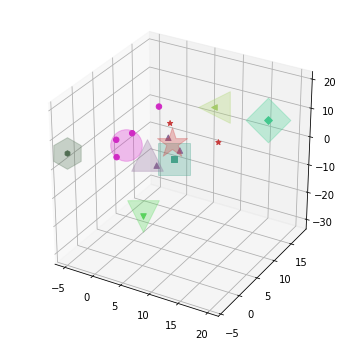

In [8]:
try_clusterize(1.2, canberra_distances)

{(0.5, 9.18, 17.0): [(0.0, 16.0, -16.0), (-1.0, 9.0, -30.0)],
 (2.07, 1.61, 1.83): [(0.0, 1.0, 1.0),
                      (0.0, 1.0, 7.0),
                      (5.0, 7.0, 4.0),
                      (0.0, 5.0, 5.0),
                      (9.0, 4.0, 5.0),
                      (7.0, 1.0, 2.0)],
 (2.6, 7.33, 3.16): [(0.0, 12.0, 7.0),
                     (-5.0, -4.0, 5.0),
                     (6.0, 18.0, 4.0)],
 (9.57, 3.33, 9.86): [(10.0, 0.0, 19.0),
                      (20.0, 10.0, 15.0),
                      (18.0, 0.0, 17.0)]}


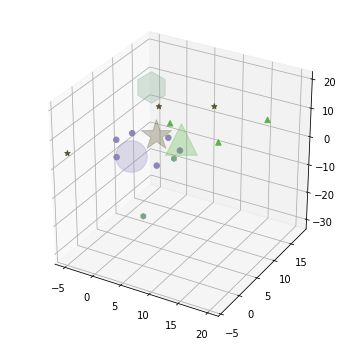

In [9]:
try_clusterize(2.2, canberra_distances)

{(2.61, 1.88, 2.79): [(0.0, 1.0, 1.0),
                      (0.0, 1.0, 7.0),
                      (5.0, 7.0, 4.0),
                      (0.0, 5.0, 5.0),
                      (9.0, 4.0, 5.0),
                      (7.0, 1.0, 2.0),
                      (10.0, 0.0, 19.0),
                      (0.0, 12.0, 7.0),
                      (-5.0, -4.0, 5.0),
                      (20.0, 10.0, 15.0)],
 (4.75, 6.43, 9.56): [(0.0, 16.0, -16.0),
                      (-1.0, 9.0, -30.0),
                      (18.0, 0.0, 17.0),
                      (6.0, 18.0, 4.0)]}


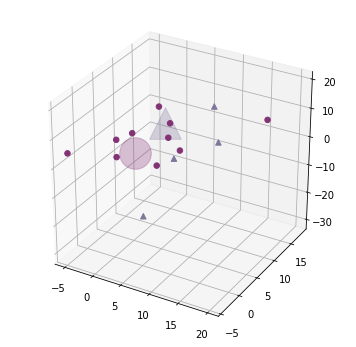

In [10]:
try_clusterize(2.5, canberra_distances)

# Вывод

Рассмотренный метод кластеризации вполне подходит для задач классификации множества образов с небольшим количеством признаков.